# Final Report  

### **Annabel Lim, Owen Kwong, Yash Mali, Yui Mikuriya (Group 20)**

In [1]:
# load libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(datateachr)

# set seed
set.seed(2023);

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# data url (zip file)
url <- "https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip"

# unzip and load data
temp <- tempfile()
download.file(url,temp)
dropout_data <- read.csv2(unz(temp, "data.csv")) 
unlink(temp)

#Clean the data 
dropout_clean <- dropout_data %>% rename(Student_Status = Target, 
                                         Admission_Grade = Admission.grade) %>% #Rename 'Target' column
  mutate(Student_Status = as_factor(Student_Status)) %>% #Convert the 'Student_Status' column to a factor
  filter(Student_Status != "Enrolled") 

#Select only the Target column 
dropout_pop <- dropout_clean %>% select(Student_Status, Admission_Grade) %>%
    mutate(Admission_Grade = as.numeric(Admission_Grade))

head(dropout_pop)

,Student_Status,Admission_Grade
,<fct>,<dbl>
1,Dropout,127.3
2,Graduate,142.5
3,Dropout,124.8
4,Graduate,119.6
5,Graduate,141.5
6,Graduate,114.8


### Getting Point Estimate

In [3]:
estimate = dropout_pop |> group_by(Student_Status) |> summarize(point_estimate = mean(Admission_Grade))
estimate

Student_Status,point_estimate
<fct>,<dbl>
Dropout,124.9614
Graduate,128.7944


## Our Hypothesis - 

$H_0: m_d-m_g = 0$

$H_1: m_d-m_g < 0$

At signifiance level is $\alpha = 5%$.

Here $m_d$ is the mean grade of the dropout candiates and $m_g$ is the mean grade of graduate candidates. We will use 2 approaches, simulation and theory based.



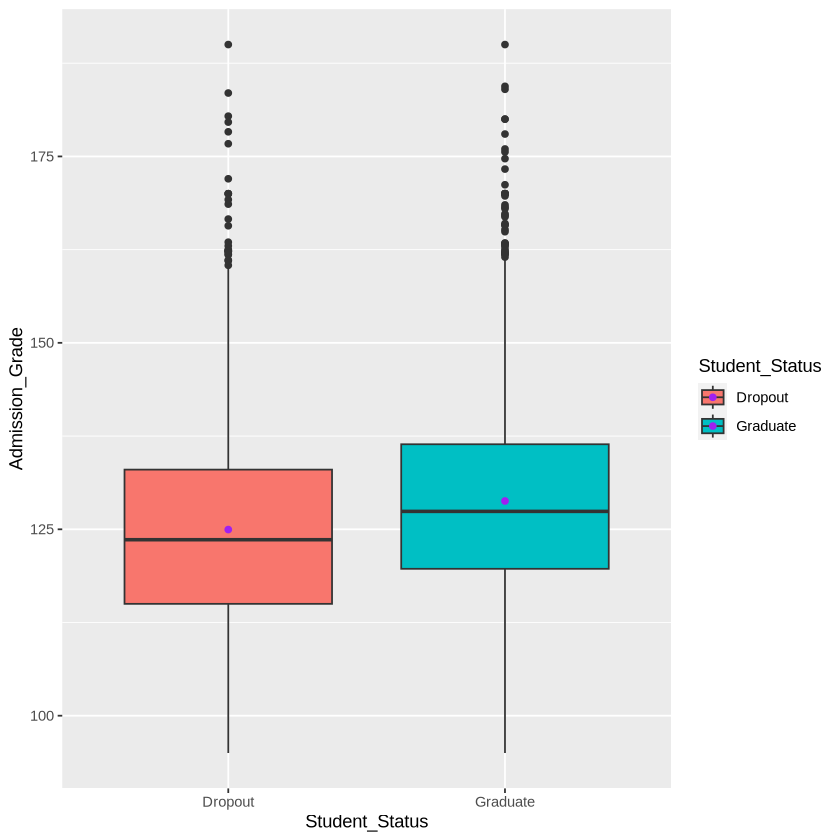

In [4]:
boxplot <-
    ggplot(dropout_pop, aes(x=Student_Status,y=Admission_Grade, fill=Student_Status)) + geom_boxplot() +
    stat_summary(fun = "mean", geom = "point", color = "purple")
boxplot

### Simulation based approach - 

In [5]:
test_stat <- dropout_pop %>%
  specify(Admission_Grade ~ Student_Status) %>%                         # Specifying the model.
  calculate(stat = "diff in means", order = c("Dropout", "Graduate"))   # Calculating the statistic.

test_stat

Dropping unused factor levels Enrolled from the supplied explanatory variable 'Student_Status'.


stat
<dbl>
-3.833067


Dropping unused factor levels Enrolled from the supplied explanatory variable 'Student_Status'.


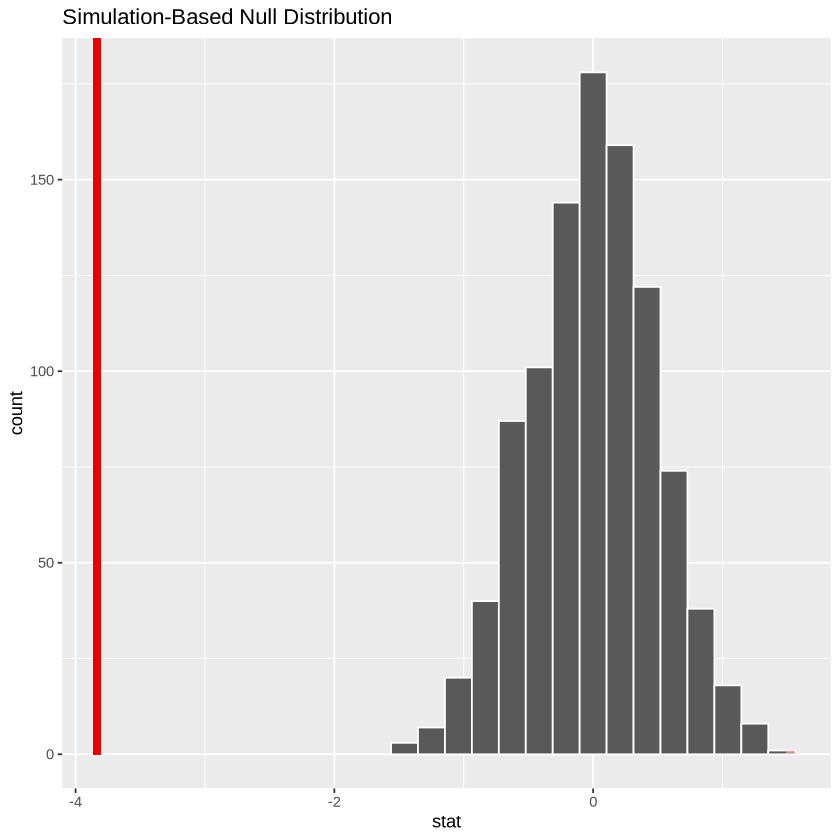

In [6]:
set.seed(2023);

null_dist <- dropout_pop %>%
  specify(Admission_Grade ~ Student_Status) %>%
  hypothesize(null="independence") %>%
  generate(type="permute", reps = 1000) %>%
  calculate(stat = "diff in means", order = c("Dropout", "Graduate"))

null_dist %>%
  visualize() +
  shade_p_value(obs_stat = test_stat, direction = "both")

In [7]:
p_value <- null_dist %>%
  get_pvalue(obs_stat = test_stat, direction = "both")

p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


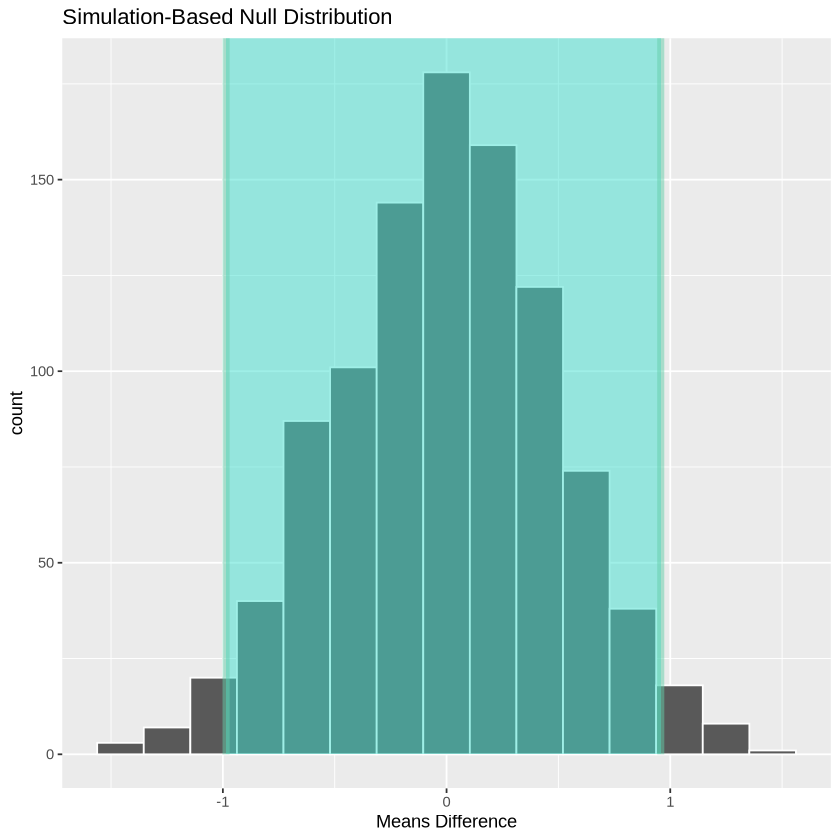

In [8]:
ci <- null_dist %>%
  get_ci(level = 0.95)

null_dist %>%
  visualize() +
  shade_ci(endpoints = ci, alpha=0.5) + xlab("Means Difference")

Clearly the p-value $\le \alpha = 0.05$. This gives us reason to suggest that we should reject $H_o$

### Theory based approach

We will use - 

$Z = \frac{\bar{x}_d - \bar{x}_g}{\sqrt{\frac{s_d^2}{n_d} + \frac{s_g2}{n_g}}}$

In [9]:
group_d <- filter(dropout_pop, Student_Status == "Dropout")$Admission_Grade
group_g <- filter(dropout_pop, Student_Status == "Graduate")$Admission_Grade

mean_d <- mean(group_d)
mean_g <- mean(group_g)
sd_d <- sd(group_d)
sd_g <- sd(group_g)
n_d <- length(group_d)
n_g <- length(group_g)

# Two-sample z-test
z_value <- (mean_d - mean_g) / sqrt((sd_d^2 / n_d) + (sd_g^2 / n_g))

# Calculate p-value (assuming a one-sided test)
p_value <- pnorm(z_value)

print(paste("z-value:", z_value))
print(paste("p-value:", p_value))


[1] "z-value: -7.65651749341328"
[1] "p-value: 9.55213715896229e-15"


Again, as we can see, the p-value is close to 0. So clearly, the p-value $\le \alpha = 0.05$. This gives us reason to suggest that we should reject $H_o$ in favour of $H_a$

This suggests that there is a statistically significant difference between the addmission grade of a dropout and graduate. 